## Import Modules

In [2]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Spark Session
spark = SparkSession.builder.appName('loan_prediction').getOrCreate()

## Load the Dataset

In [4]:
df = spark.read.csv('/content/Loan_Dataset.csv', header=True, sep=',', inferSchema=True)
df.show(5)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001000|  Male|     No|         0|    Graduate|           No|           6155|              0.0|      NULL|           360.0|           1.0|        Urban|          Y|
|LP001001|  Male|    Yes|         1|    Graduate|           No|           4442|           1508.0|     136.0|           360.0|           1.0|        Rural|          N|
|LP001002|  Male|    Yes|         0|    Graduate|          Yes|           2998|              0.0|      60.0|           360.0|           1.0|        Urban|          Y

In [5]:
df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- Loan_Amount_Term: double (nullable = true)
 |-- Credit_History: double (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



In [ ]:
pandas_df = df.toPandas()
pandas_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001000,Male,No,0,Graduate,No,6155,0.0,NaN,360.0,1.0,Urban,Y
1,LP001001,Male,Yes,1,Graduate,No,4442,1508.0,136.0,360.0,1.0,Rural,N
2,LP001002,Male,Yes,0,Graduate,Yes,2998,0.0,60.0,360.0,1.0,Urban,Y
3,LP001003,Male,Yes,0,Not Graduate,No,2138,2358.0,124.0,360.0,1.0,Urban,Y
4,LP001004,Male,No,0,Graduate,No,6124,0.0,137.0,360.0,1.0,Urban,Y


In [9]:
pandas_df.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
49115,LP050115,Female,No,0,Graduate,No,2964,0.0,68.0,360.0,1.0,Rural,Y
49116,LP050116,Male,Yes,3+,Graduate,No,4110,0.0,35.0,180.0,1.0,Rural,Y
49117,LP050117,Male,Yes,1,Graduate,No,8090,240.0,252.0,360.0,1.0,Urban,Y
49118,LP050118,Male,Yes,2,Graduate,No,7415,0.0,184.0,360.0,1.0,Urban,Y
49119,LP050119,Female,No,0,Graduate,Yes,4680,0.0,123.0,360.0,0.0,Semiurban,N


## Data Analysis

In [ ]:
df.groupBy('Loan_Status').count().show()

+-----------+-----+
|Loan_Status|count|
+-----------+-----+
|          Y|33760|
|          N|15360|
+-----------+-----+



In [11]:
df.select("Credit_History", "Loan_Status").groupBy('Loan_Status').agg(F.avg('Credit_History')).show()

+-----------+-------------------+
|Loan_Status|avg(Credit_History)|
+-----------+-------------------+
|          Y| 0.9818181818181818|
|          N| 0.5418994413407822|
+-----------+-------------------+



In [12]:
df.select('Gender', 'Loan_Status').groupBy('Loan_Status', 'Gender').count().show()

+-----------+------+-----+
|Loan_Status|Gender|count|
+-----------+------+-----+
|          N|Female| 2960|
|          Y|  NULL|  640|
|          Y|Female| 6000|
|          N|  NULL|  400|
|          Y|  Male|27120|
|          N|  Male|12000|
+-----------+------+-----+



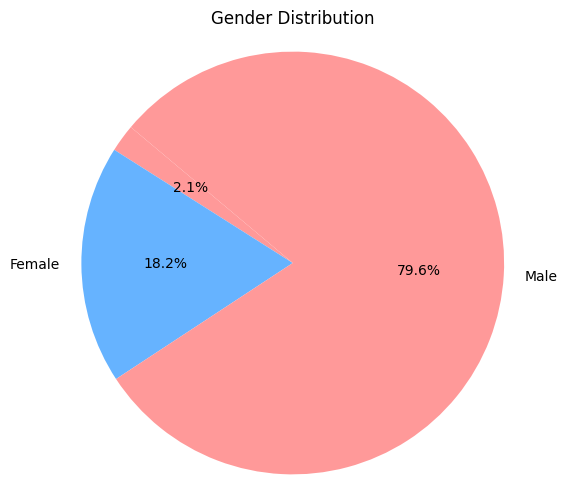

In [ ]:
import matplotlib.pyplot as plt
gender_counts_spark = df.groupBy("Gender").count()
gender_counts = gender_counts_spark.toPandas()

plt.figure(figsize=(6, 6))
plt.pie(
    gender_counts["count"],
    labels=gender_counts["Gender"],
    autopct='%1.1f%%',
    startangle=140,
    colors=[ '#ff9999', '#66b3ff']
)

plt.title("Gender Distribution")
plt.axis('equal')
plt.show()


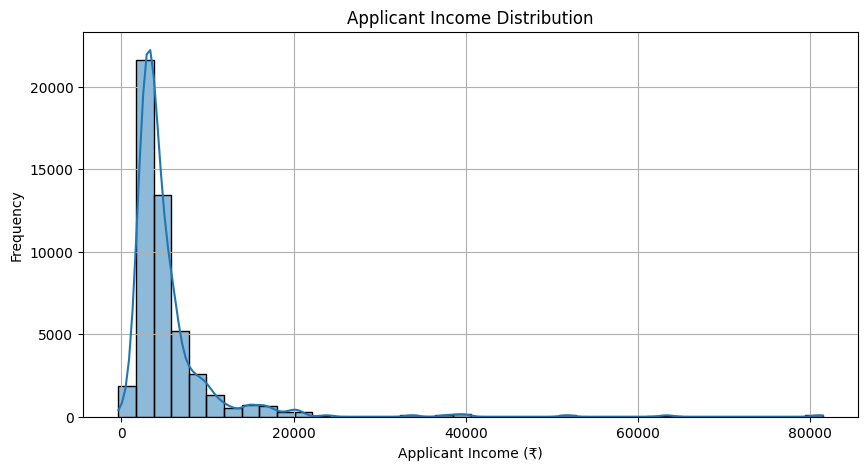

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(pandas_df['ApplicantIncome'], bins=40, kde=True)
plt.title('Applicant Income Distribution')
plt.xlabel('Applicant Income (₹)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


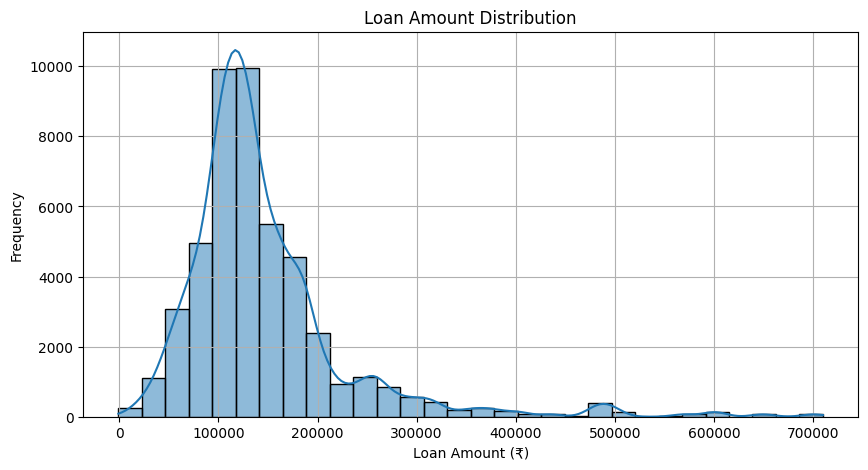

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(pandas_df['LoanAmount'] * 1000, bins=30, kde=True)
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount (₹)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Correlation Matrix

In [18]:
columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
corr_df = pd.DataFrame()
for i in columns:
    corr = []
    for j in columns:
        corr.append(round(df.stat.corr(i, j), 2))
    corr_df = pd.concat([corr_df, pd.Series(corr)], axis=1)
corr_df.columns = columns
corr_df.insert(0, '', columns)
corr_df.set_index('')

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
,,,,,
ApplicantIncome,1.00,-0.12,0.54,-0.02,0.01
CoapplicantIncome,-0.12,1.00,0.19,-0.05,-0.06
LoanAmount,0.54,0.19,1.00,0.06,-0.03
Loan_Amount_Term,-0.02,-0.05,0.06,1.00,0.05
Credit_History,0.01,-0.06,-0.03,0.05,1.00


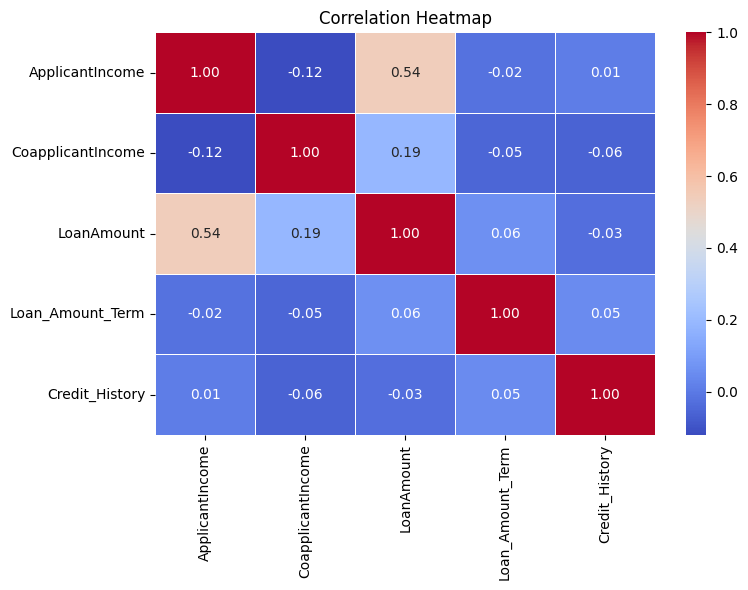

In [ ]:
import pandas as pd
import seaborn as sns

columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

corr_df = pd.DataFrame()
for i in columns:
    corr = []
    for j in columns:
        corr.append(round(df.stat.corr(i, j), 2))
    corr_df = pd.concat([corr_df, pd.Series(corr)], axis=1)
corr_df.columns = columns
corr_df.index = columns  

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


## Perform SQL Operations

In [20]:
import pyspark.sql as sparksql

In [21]:
df.createOrReplaceTempView('table')

In [ ]:
spark.sql("select * from table limit 5").show()

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001000|  Male|     No|         0|    Graduate|           No|           6155|              0.0|      NULL|           360.0|           1.0|        Urban|          Y|
|LP001001|  Male|    Yes|         1|    Graduate|           No|           4442|           1508.0|     136.0|           360.0|           1.0|        Rural|          N|
|LP001002|  Male|    Yes|         0|    Graduate|          Yes|           2998|              0.0|      60.0|           360.0|           1.0|        Urban|          Y

In [23]:
spark.sql('select Loan_ID from table where Credit_History=1').show()

+--------+
| Loan_ID|
+--------+
|LP001000|
|LP001001|
|LP001002|
|LP001003|
|LP001004|
|LP001005|
|LP001006|
|LP001008|
|LP001009|
|LP001010|
|LP001011|
|LP001012|
|LP001013|
|LP001014|
|LP001015|
|LP001018|
|LP001019|
|LP001021|
|LP001025|
|LP001026|
+--------+
only showing top 20 rows



## Data Cleaning

In [ ]:
null=df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|      0|  1040|    240|      1200|        0|         2560|              0|                0|      1760|            1120|          4000|            0|          0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



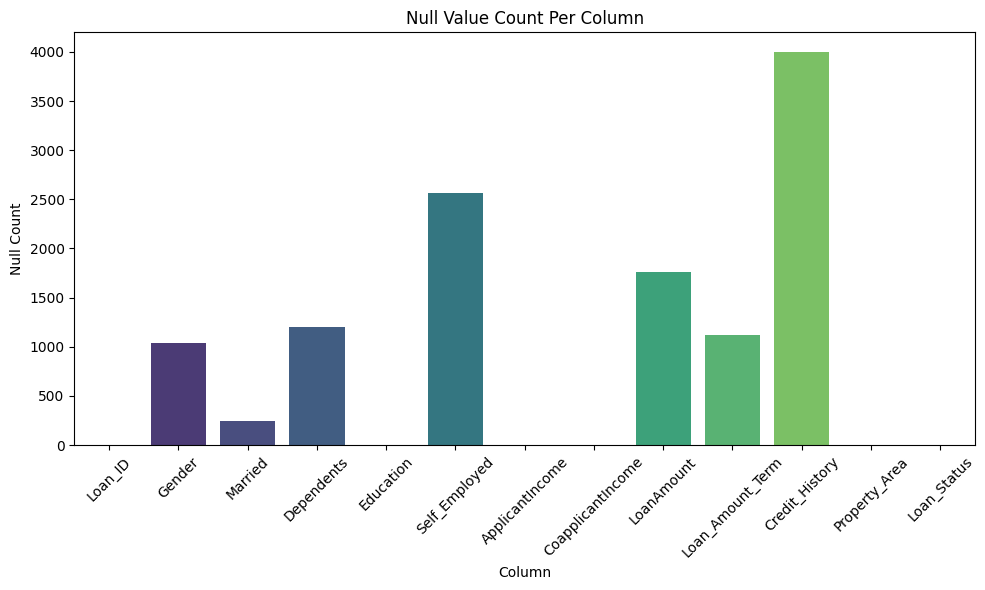

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts_dict = null_counts.collect()[0].asDict()

null_df = pd.DataFrame(list(null_counts_dict.items()), columns=['Column', 'Null Count'])

plt.figure(figsize=(10, 6))
sns.barplot(data=null_df, x='Column', y='Null Count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Null Value Count Per Column')
plt.tight_layout()
plt.show()


In [ ]:
mean = df.select(F.mean(df['LoanAmount'])).collect()[0][0]
mean

146.40641891891892

In [ ]:
df = df.na.fill(mean, ['LoanAmount'])

In [ ]:
df.groupby('Gender').count().orderBy("count", ascending=False).first()[0]

'Male'

In [ ]:
numerical_cols = ['LoanAmount', 'Loan_Amount_Term']
categorical_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']

In [30]:
for col in numerical_cols:
    mean = df.select(F.mean(df[col])).collect()[0][0]
    df = df.na.fill(mean, [col])

In [31]:
for col in categorical_cols:
    mode = df.groupby(col).count().orderBy("count", ascending=False).first()[0]
    df = df.na.fill(mode, [col])

In [ ]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|      0|     0|      0|         0|        0|            0|              0|                0|         0|               0|             0|            0|          0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



In [ ]:
df = df.withColumn('TotalIncome', F.col('ApplicantIncome') + F.col('CoapplicantIncome'))
df.show(2)

+--------+------+-------+----------+---------+-------------+---------------+-----------------+------------------+----------------+--------------+-------------+-----------+-----------+
| Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|        LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|TotalIncome|
+--------+------+-------+----------+---------+-------------+---------------+-----------------+------------------+----------------+--------------+-------------+-----------+-----------+
|LP001000|  Male|     No|         0| Graduate|           No|           6155|              0.0|146.40641891891892|           360.0|           1.0|        Urban|          Y|     6155.0|
|LP001001|  Male|    Yes|         1| Graduate|           No|           4442|           1508.0|             136.0|           360.0|           1.0|        Rural|          N|     5950.0|
+--------+------+-------+----------+---------+-------------+---------------+----

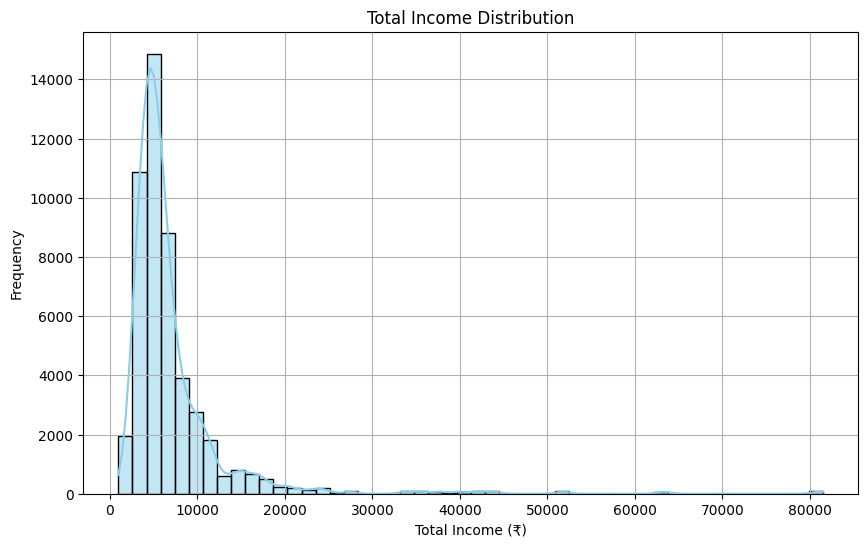

In [ ]:
df_pd = df.select("TotalIncome").toPandas()

plt.figure(figsize=(10,6))
sns.histplot(df_pd["TotalIncome"], bins=50, kde=True, color='skyblue')
plt.title("Total Income Distribution")
plt.xlabel("Total Income (₹)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
df = df.withColumn('Loan_Status', F.when(df['Loan_Status']=='Y', 1).otherwise(0))
df.show(2)

+--------+------+-------+----------+---------+-------------+---------------+-----------------+------------------+----------------+--------------+-------------+-----------+-----------+
| Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|        LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|TotalIncome|
+--------+------+-------+----------+---------+-------------+---------------+-----------------+------------------+----------------+--------------+-------------+-----------+-----------+
|LP001000|  Male|     No|         0| Graduate|           No|           6155|              0.0|146.40641891891892|           360.0|           1.0|        Urban|          1|     6155.0|
|LP001001|  Male|    Yes|         1| Graduate|           No|           4442|           1508.0|             136.0|           360.0|           1.0|        Rural|          0|     5950.0|
+--------+------+-------+----------+---------+-------------+---------------+----

## Feature Engineering

In [36]:
df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = false)
 |-- Married: string (nullable = false)
 |-- Dependents: string (nullable = false)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = false)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: double (nullable = false)
 |-- Loan_Amount_Term: double (nullable = false)
 |-- Credit_History: double (nullable = false)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: integer (nullable = false)
 |-- TotalIncome: double (nullable = true)



In [37]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

In [ ]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'TotalIncome']

indexers = [StringIndexer(inputCol=col, outputCol="{0}_index".format(col)) for col in categorical_columns]
encoders = [OneHotEncoder(dropLast=False, inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
           for indexer in indexers]
input_columns = [encoder.getOutputCol() for encoder in encoders] + numerical_columns

assembler = VectorAssembler(inputCols=input_columns, outputCol="feature")

In [ ]:
#pipeline
pipeline = Pipeline(stages = indexers + encoders + [assembler])

In [40]:
data_model = pipeline.fit(df)

In [41]:
transformed_df = data_model.transform(df)

In [42]:
transformed_df.show(1)

+--------+------+-------+----------+---------+-------------+---------------+-----------------+------------------+----------------+--------------+-------------+-----------+-----------+------------+-------------+----------------+---------------+-------------------+-------------------+--------------------+--------------------+---------------------+------------------------+-----------------------+---------------------------+---------------------------+----------------------------+--------------------+
| Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|        LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|TotalIncome|Gender_index|Married_index|Dependents_index|Education_index|Self_Employed_index|Property_Area_index|Credit_History_index|Gender_index_encoded|Married_index_encoded|Dependents_index_encoded|Education_index_encoded|Self_Employed_index_encoded|Property_Area_index_encoded|Credit_History_index_encoded|             fea

In [ ]:
transformed_df = transformed_df.select(['feature', 'Loan_Status'])

In [44]:
transformed_df.show(20)

+--------------------+-----------+
|             feature|Loan_Status|
+--------------------+-----------+
|(22,[0,3,4,8,10,1...|          1|
|(22,[0,2,5,8,10,1...|          0|
|(22,[0,2,4,8,11,1...|          1|
|(22,[0,2,4,9,10,1...|          1|
|(22,[0,3,4,8,10,1...|          1|
|(22,[0,2,6,8,11,1...|          1|
|(22,[0,2,4,9,10,1...|          1|
|(22,[0,2,7,8,10,1...|          0|
|(22,[0,2,6,8,10,1...|          1|
|(22,[0,2,5,8,10,1...|          0|
|(22,[0,2,6,8,10,1...|          1|
|(22,[0,2,6,8,10,1...|          1|
|(22,[0,2,6,8,10,1...|          1|
|(22,[0,3,4,8,10,1...|          0|
|(22,[0,2,6,8,10,1...|          1|
|(22,[0,3,4,8,10,1...|          1|
|(22,[0,3,5,9,10,1...|          1|
|(22,[1,3,4,8,10,1...|          0|
|(22,[0,2,4,9,10,1...|          0|
|(22,[0,2,4,8,10,1...|          1|
+--------------------+-----------+
only showing top 20 rows



In [ ]:
train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed=42)

In [46]:
train_data.show(5)

+--------------------+-----------+
|             feature|Loan_Status|
+--------------------+-----------+
|(22,[0,2,4,8,10,1...|          1|
|(22,[0,2,4,8,10,1...|          1|
|(22,[0,2,4,8,10,1...|          1|
|(22,[0,2,4,8,10,1...|          1|
|(22,[0,2,4,8,10,1...|          1|
+--------------------+-----------+
only showing top 5 rows



## Model Training & Testing

In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator


##Logistic Regression

In [48]:
lr = LogisticRegression(featuresCol='feature', labelCol='Loan_Status')
lr_model = lr.fit(train_data)

In [66]:
predictions = lr_model.transform(test_data)
predictions.show(5)

+--------------------+-----------+--------------------+--------------------+----------+
|             feature|Loan_Status|       rawPrediction|         probability|prediction|
+--------------------+-----------+--------------------+--------------------+----------+
|(22,[0,2,4,8,10,1...|          1|[-2.0481110659642...|[0.11424338674517...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.0803232517595...|[0.11102405848897...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.0607946018434...|[0.11296618264362...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.0513914113179...|[0.11391186239146...|       1.0|
|(22,[0,2,4,8,10,1...|          1|[-2.3541602586131...|[0.08673566051743...|       1.0|
+--------------------+-----------+--------------------+--------------------+----------+
only showing top 5 rows



In [67]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol='Loan_Status', predictionCol='prediction', metricName='accuracy')
lr_accuracy = acc_evaluator.evaluate(predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Logistic Regression Accuracy: 0.8162


##Linear SVC

In [64]:
svc = LinearSVC(labelCol="Loan_Status", featuresCol="feature")
svc_model = svc.fit(train_data)
svc_predictions = svc_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="Loan_Status", predictionCol="prediction", metricName="accuracy")
svc_accuracy = evaluator.evaluate(svc_predictions)
print(f"Linear SVC Accuracy: {svc_accuracy:.4f}")

Linear SVC Accuracy: 0.8128


##Decision Trees

In [62]:

dt = DecisionTreeClassifier(labelCol="Loan_Status", featuresCol="feature")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="Loan_Status", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")



Decision Tree Accuracy: 0.8402


##Random Forest

In [70]:
rf = RandomForestClassifier(featuresCol='feature', labelCol='Loan_Status')
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

In [71]:
evaluator = MulticlassClassificationEvaluator(labelCol="Loan_Status", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)  # Now using the correct rf_predictions
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.8257
